#  CottonNet: Cotton Disease Prediction using ResNet50
### Using Advanced techniques like :
* Transfer Learning
* Data Augmentation

In [22]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout

## Fetch / Load the data

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d janmejaybhoi/cotton-disease-dataset

 95% 140M/148M [00:01<00:00, 94.8MB/s]
100% 148M/148M [00:01<00:00, 92.8MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cotton-disease-dataset.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

## Data Augmentation

In [6]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [7]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    '/content/Cotton Disease/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/Cotton Disease/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1951 images belonging to 4 classes.
Found 106 images belonging to 4 classes.


## Build the CNN model

### Load the Resnet50 model and freeze its conv_base

In [9]:
resnet_model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [11]:
# Freezing the conv_base of resnet_model
for layer in resnet_model.layers:
  layer.trainable = False

In [13]:
flatten = Flatten()(resnet_model.output)
dense1 = Dense(64, activation='relu')(flatten)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(4, activation='softmax')(dense2)

resnet_model = Model(inputs=resnet_model.input, outputs=output)

In [15]:
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

In [17]:
history = resnet_model.fit_generator(train_generator, epochs=10, validation_data=test_generator)

<ipython-input-17-5eb2347cf0c8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = resnet_model.fit_generator(train_generator, epochs=10, validation_data=test_generator)


Epoch 1/10
61/61 [==============================] - 65s 821ms/step - loss: 1.5157 - accuracy: 0.3655 - val_loss: 1.2790 - val_accuracy: 0.4151
Epoch 2/10
61/61 [==============================] - 41s 672ms/step - loss: 1.2017 - accuracy: 0.4782 - val_loss: 1.3047 - val_accuracy: 0.3962
Epoch 3/10
61/61 [==============================] - 48s 786ms/step - loss: 1.1342 - accuracy: 0.5182 - val_loss: 1.0747 - val_accuracy: 0.5849
Epoch 4/10
61/61 [==============================] - 39s 640ms/step - loss: 1.0813 - accuracy: 0.5510 - val_loss: 1.0863 - val_accuracy: 0.5189
Epoch 5/10
61/61 [==============================] - 50s 821ms/step - loss: 1.0696 - accuracy: 0.5464 - val_loss: 1.0986 - val_accuracy: 0.5000
Epoch 6/10
61/61 [==============================] - 47s 781ms/step - loss: 1.0100 - accuracy: 0.5664 - val_loss: 0.8687 - val_accuracy: 0.6792
Epoch 7/10
61/61 [==============================] - 40s 659ms/step - loss: 0.9774 - accuracy: 0.6115 - val_loss: 1.0066 - val_accuracy: 0.6132

## Plotting the accuracy and loss over time during each epoch

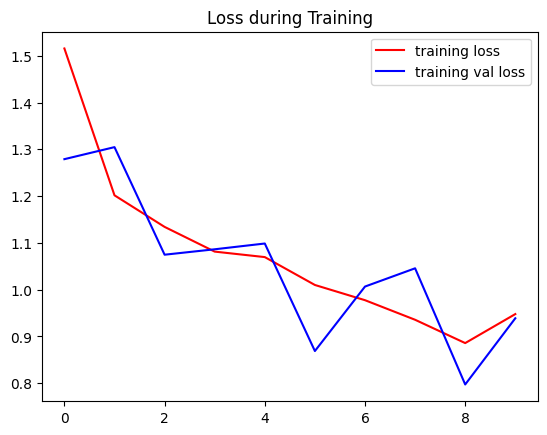

In [18]:
plt.title('Loss during Training')
plt.plot(history.history['loss'], color='red', label='training loss')
plt.plot(history.history['val_loss'], color='blue', label='training val loss')
plt.legend()
plt.show()

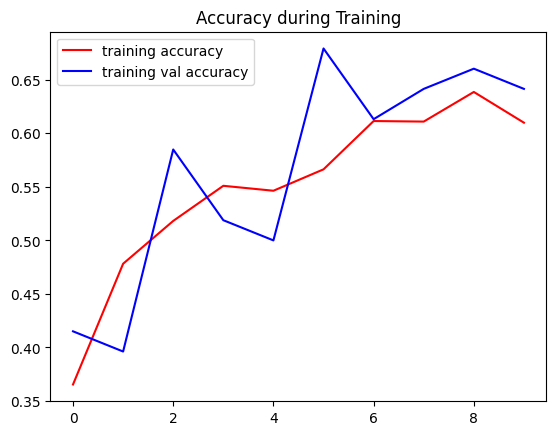

In [19]:
plt.title('Accuracy during Training')
plt.plot(history.history['accuracy'], color='red', label='training accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='training val accuracy')
plt.legend()
plt.show()

## Testing the model

In [39]:
preds = resnet_model.predict(test_generator)

4/4 [==============================] - 6s 1s/step


In [40]:
preds

array([[9.95769799e-01, 4.90558741e-04, 3.69647285e-03, 4.31178778e-05],
       [2.53537633e-02, 7.11160362e-01, 2.04626061e-02, 2.43023321e-01],
       [7.53726903e-03, 1.65162206e-01, 2.43190855e-01, 5.84109664e-01],
       [9.98838339e-03, 4.10190791e-01, 4.52445373e-02, 5.34576297e-01],
       [3.50245349e-02, 4.21667695e-01, 1.65784866e-01, 3.77522886e-01],
       [9.45585310e-01, 3.42840469e-03, 5.02887405e-02, 6.97507523e-04],
       [2.99397986e-02, 3.15342873e-01, 2.68211216e-01, 3.86506140e-01],
       [2.28263456e-02, 5.98096192e-01, 1.50787206e-02, 3.63998741e-01],
       [2.86111593e-01, 5.04298834e-03, 6.67021453e-01, 4.18239273e-02],
       [1.61683541e-02, 2.24361315e-01, 2.97558218e-01, 4.61912125e-01],
       [2.99706291e-02, 6.14119768e-01, 5.31043112e-02, 3.02805275e-01],
       [7.36543387e-02, 5.43765187e-01, 1.45857006e-01, 2.36723423e-01],
       [1.44836148e-02, 5.54006040e-01, 3.00157703e-02, 4.01494592e-01],
       [9.08394814e-01, 4.94765304e-03, 8.37658718e

## Saving the Model

In [43]:
resnet_model.save('resnet_cottonet.h5')